In [85]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
import json
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import utils
import math
from scipy.stats import norm
colors = sns.color_palette("Set2")

In [152]:
df = pd.read_csv('/Users/shariqiqbal/data/tcds-fear/data/103a_12-11-15_light/oddball/livedata.csv')
params = json.load(open('/Users/shariqiqbal/data/tcds-fear/data/103a_12-11-15_light/oddball/oddball_projID-3f3yksr_recID-y4p5kho.json'))

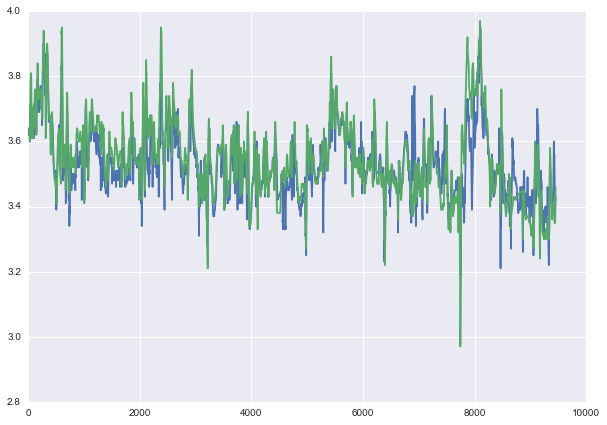

In [153]:
plt.figure(figsize=(10,7))
plt.plot(df.l_pup_diam.values)
plt.hold()
plt.plot(df.r_pup_diam.values);

In [154]:
pup_diam = (df.r_pup_diam + df.l_pup_diam)/2

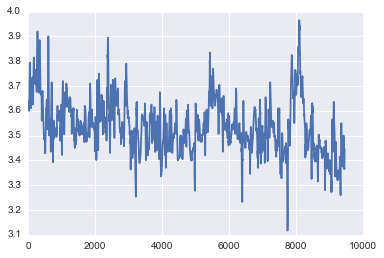

In [155]:
plt.plot(pup_diam);

In [156]:
def get_chunk(i, data):
    """
    Returns a slice from data, starting slightly before index i
    and ending after.
    """
    try:
        if i + 150 > len(data):
            return np.hstack((data[i - 15:], np.zeros(i + 150 - len(data))))
        else:
            return data[i - 15:i + 150]
    except IndexError:
        return None
def gauss_convolve(x, sigma):
    edge = int(math.ceil(5 * sigma))
    fltr = norm.pdf(range(-edge, edge), loc=0, scale=sigma)
    fltr = fltr / sum(fltr)

    buff = np.ones((1, edge))[0]

    szx = x.size

    xx = np.append((buff * x[0]), x)
    xx = np.append(xx, (buff * x[-1]))

    y = np.convolve(xx, fltr, mode='valid')
    y = y[:szx]
    return y
def plot_with_sem(x, color):
    ntrials = x.shape[0]
    smwid = 2
    bin_t = np.array(range(x.shape[1]))

    xm = x.mean(axis=0)
    sd = x.std(axis=0)
    effsamp = np.sum(np.logical_not(np.isnan(x)), 0)
    sem = sd / np.sqrt(effsamp)
    sem = list(sem)

    xsm = gauss_convolve(xm, smwid)
    xhi = gauss_convolve(xm + sem, smwid)
    xlo = gauss_convolve(xm - sem, smwid)

    plt.hold(True)
    x_ptch = np.append(bin_t, bin_t[::-1])
    y_ptch = np.append(xlo, xhi[::-1])

    if ntrials > 1:
        plt.fill(
            x_ptch, y_ptch, color=color, alpha=0.25, edgecolor=None)

    plt.plot(bin_t, xsm, color=color, linewidth=2.0)
    plt.hold(False)

Manually find frame where sync blip occurs

In [158]:
sync_frame = 7

In [159]:
df = df[~df.vts_time.isnull()] # start df where video starts

In [160]:
df = df.iloc[sync_frame*2:]  # cut to where sync blip happens

In [161]:
def norm_trials(trials, interval, mode='sub'):
    """
    Baseline normalize trials from from interval
    """
    if mode == 'sub':
        return trials - np.tile(trials[:, interval[0]:interval[1]].mean(axis=1)[:, np.newaxis], trials.shape[1])
    elif mode == 'div':
        return trials / np.tile(trials[:, interval[0]:interval[1]].mean(axis=1)[:, np.newaxis], trials.shape[1])
    else:
        print "Mode not recognized. Returning un-normalized data"
        return trials

In [175]:
i = 0
targ_trials = []
other_trials = []
for j in range(len(df.seconds.values)):
    t = df.seconds.iloc[j] - df.seconds.iloc[0] + params['start_time'] # convert tobii time to psychopy time
    if t > params['soundtime'][i]:
        chunk = get_chunk(j, pup_diam.values)
        if chunk is not None:
            if params['trialvec'][i] == 1.0:
                targ_trials.append(chunk)
            elif params['trialvec'][i] == 0.0:
                other_trials.append(chunk)
        i += 1
        if i >= len(params['soundtime']):
            break
targ_trials = np.array(targ_trials)
other_trials = np.array(other_trials)

In [176]:
targ_norm = norm_trials(targ_trials, (0, 15), mode='sub')
other_norm = norm_trials(other_trials, (0, 15), mode='sub')

In [177]:
targ_mean = targ_norm.mean(axis=0)
other_mean = other_norm.mean(axis=0)

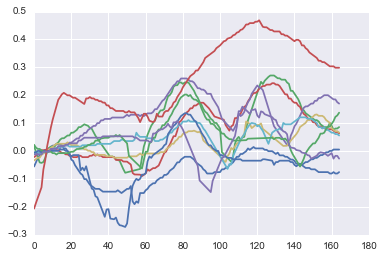

In [178]:
plt.plot(targ_norm.T);

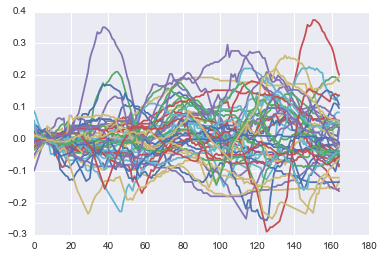

In [179]:
plt.plot(other_norm.T);

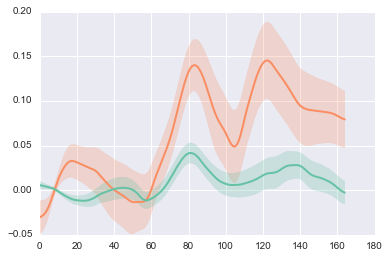

In [180]:
plot_with_sem(targ_norm, colors[1])
plot_with_sem(other_norm, colors[0]);

* Median (instead of mean) across trials
* Use seaborn tsplot. Input: df

sns.tsplot(data=df, time="freq", unit="pair",
              condition="variable", value="value",
              ci=95)